In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Set up three constants
- a minimum precision (twice the actual minimum precision, as a precaution; note that eps is defined for 1.0+eps, not for very large numbers). This is a computer constraint
- our critical point. This is a physical constraint
- the value at the critical point (our starting condition)

In [2]:
EPS = 2 * np.finfo(np.float64).eps
RC = 2.5
RCY = 1.0

The differential equation. When at (very close to) the critical point, the result is a simple constant.

In [3]:
def func(t, y):
    return 2 / RC if abs(t - RC) < EPS else (4 * y * (t - RC)) /  ((y - RCY) * t**2)

If the above one-liner doesn't read nicely, just write it out across multiple lines. The evaluation speed will not noticeably change. 

There is also an additional check on `y - RCY` not being `0`, since we divide by it. This shouldn't be necessary (it is not used above), since the test for `t - RC` automatically takes care of that, but since we're dealing with computer precision, not mathematical precision, there may be circumstances that only one of the two conditions actually applies.

In [4]:
def func2(t, y):
    dt = t - RC
    dy = y - RCY
    if abs(dt) < EPS or abs(dy) < EPS:
        return 2 / RC
    else:
        a = 4 * y * dt
        b = dy * t**2
        return a/b

## Solve the different equation.

Since we set our starting value at RC, and we want to solve on either side of RC, we need to do this in two steps.
The results, `r1` and `r2`, are dictionaries that contain, among others, the computed `t` and `y` values, which we need to concatenate together.

Notes:
- `y` is two-dimensional (we can solve for multiple starting values at once); hence we need an extra `[0]` index for `y`
- related to the above point, `y0` requires a list or array as input (but here, we only use one starting value)
- since the first computation is backwards, we need to reverse the `t` and `y` solution arrays in `r1`, using the `[::-1]` index (negative step of 1)
- concatenate requires the inputs to be inside a list or tuple, hence the double parentheses (tuple inside a function call)

In [5]:
r1 = solve_ivp(func, (RC, 0.5), y0=[1])
r2 = solve_ivp(func, (RC, 4.5), y0=[1])
t = np.concatenate((r1['t'][::-1], r2['t']))
y = np.concatenate((r1['y'][0][::-1], r2['y'][0]))

Plot the figure. The `'-o'` argument means to use a line (`'-'`) and dots (`'-'`) together as the symbols for our data.

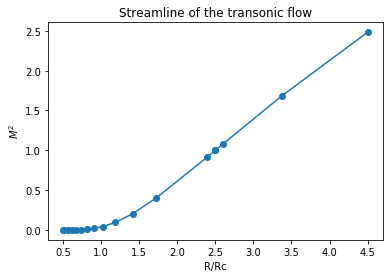

In [6]:
plt.plot(t, y, '-o', )
plt.xlabel('R/Rc')
plt.ylabel('$M^2$')
plt.title('Streamline of the transonic flow');

Let's examine the sensitivity of the equation, using a small range of starting values at minimum r value (thus not `RC`) as an input disturbance. We only integrate up to `RC`.

We make use of the fact that `y`, and thus `y0`, can be multi-dimensional in `solve_ivp`.

In [7]:
from scipy.stats import norm
t0, y0 = t[0], y[0]
ystart = y0 + np.linspace(-1e-6, 1e-6, 20)

In [8]:
r = solve_ivp(func, (t0, RC), y0=ystart)

Matplotlib is convenient enough that we can plot multiple lines in one call, although we have to transpose the `y` array.

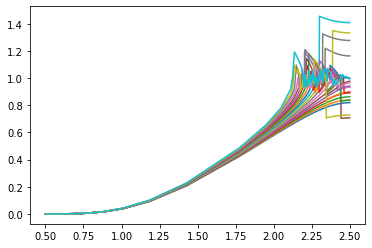

In [9]:
plt.plot(r['t'], r['y'].T) ;

Values above 1 show problems, where the solver can't integrate properly.
Let's silence all the values where the increase in `y` is negative, *and* those after (see the curve, where the data increase again after the jump): we set those values to NaN, so Matplotlib will ignore them.

We test where the increase is negative, yielding a boolean array, and cumulatively sum that array, so that any point beyond the first decrease is 1 or larger. We use that as our mask.
We can only compuate n-1 steps differences, so we apply them to the points from index 1.

In [10]:
y = r['y'].T.copy()
dy = np.diff(y, axis=0)
bad = (dy < 0).cumsum(axis=0) > 0
y[1:,:][bad] = np.nan

We also use a different style ([overview of styles](https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html)) and increase the figure size.

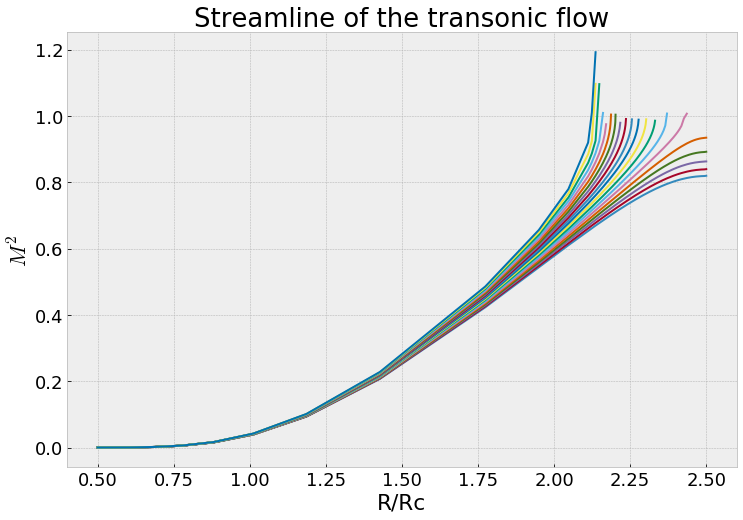

In [11]:
plt.style.use('bmh')
plt.rcParams["font.size"] = 18
plt.figure(figsize=(12, 8))

plt.plot(r['t'], y, '-')
plt.xlabel('R/Rc')
plt.ylabel('$M^2$')
plt.title('Streamline of the transonic flow');